In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-attendance-3.txt')
data.head()

,PersonID,A,Score,Weather,Y
0,1,0,69,B,1
1,1,0,69,A,1
2,1,0,69,C,1
3,1,0,69,A,1
4,1,0,69,B,1


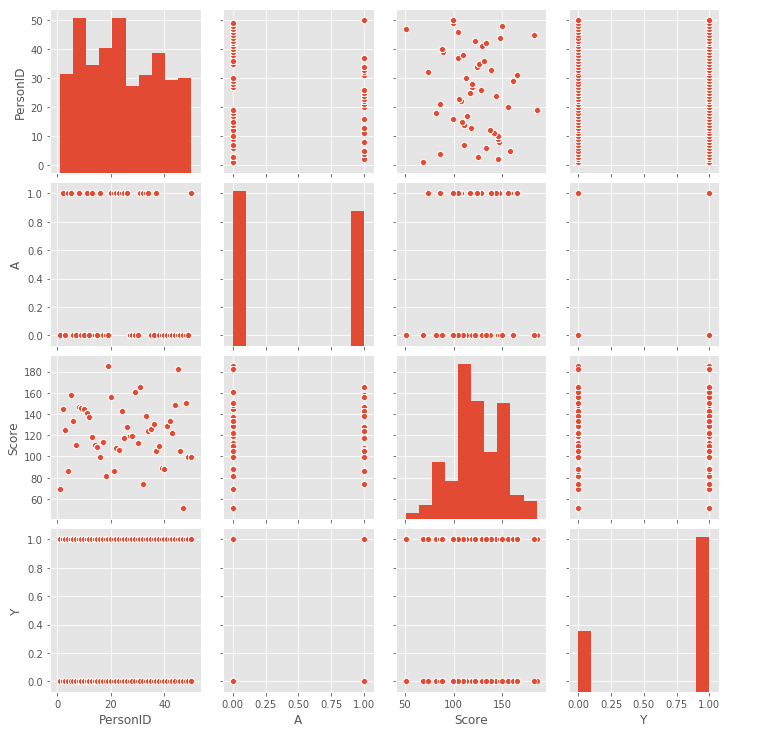

In [3]:
sns.pairplot(data)

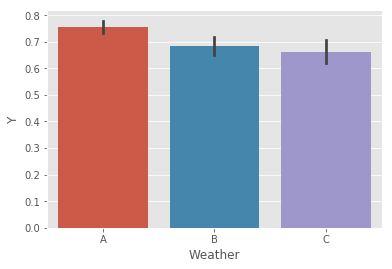

In [4]:
sns.barplot(data=data, x='Weather', y='Y', order=sorted(data['Weather'].unique()))

In [5]:
weather2value = {'A':0, 'B':0.2, 'C':1}
data['Weather'] = data['Weather'].replace(weather2value)
data['Score'] = data['Score'] / 200
data.head()

,PersonID,A,Score,Weather,Y
0,1,0,0.345,0.2,1
1,1,0,0.345,0.0,1
2,1,0,0.345,1.0,1
3,1,0,0.345,0.0,1
4,1,0,0.345,0.2,1


In [6]:
stan_model = """

data {
  int I;
  int<lower=0, upper=1> A[I];
  real<lower=0, upper=1> Score[I];
  real<lower=0, upper=1> W[I];
  int<lower=0, upper=1> Y[I];
}

parameters {
  real b[4];
}

transformed parameters {
  real q[I];
  for (i in 1:I){
    q[i] = inv_logit(b[1] + b[2] * A[i] + b[3] * Score[i] + b[4] * W[i]);
  }
}


model {
  for (i in 1:I){
    Y[i] ~ bernoulli(q[i]);
  }
}

"""

In [7]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3ec92ae305a167dfca68c5252d9e39df NOW.


In [8]:
stan_data = {}
stan_data['I'] = data.shape[0]
stan_data['A'] = data['A']
stan_data['Score'] = data['Score']
stan_data['W'] = data['Weather']
stan_data['Y'] = data['Y']

In [9]:
fit = sm.sampling(stan_data)

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [10]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_3ec92ae305a167dfca68c5252d9e39df.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b[1]    0.17  5.5e-3   0.23   -0.3   0.02   0.17   0.32   0.62   1788    1.0
b[2]   -0.62  1.8e-3   0.09   -0.8  -0.68  -0.62  -0.56  -0.44   2713    1.0
b[3]    1.96  8.7e-3   0.37   1.25   1.71   1.96   2.21   2.68   1763    1.0
b[4]   -0.46  2.6e-3   0.13  -0.71  -0.55  -0.47  -0.38  -0.21   2523    1.0
q[1]    0.68  5.8e-4   0.03   0.63   0.66   0.68    0.7   0.73   1858    1.0
q[2]     0.7  5.5e-4   0.02   0.65   0.68    0.7   0.72   0.75   2034    1.0
q[3]    0.59  8.5e-4   0.04   0.52   0.57   0.59   0.62   0.66   1866    1.0
q[4]     0.7  5.5e-4   0.02   0.65   0.68    0.7   0.72   0.75   2034    1.0
q[5]    0.68  5.8e-4   0.03   0.63   0.66   0.68    0.7   0.73   1858    1.0
q

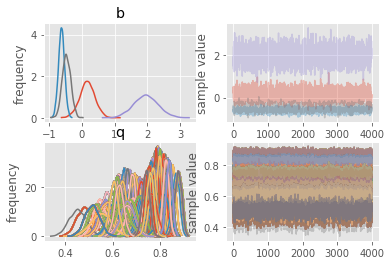

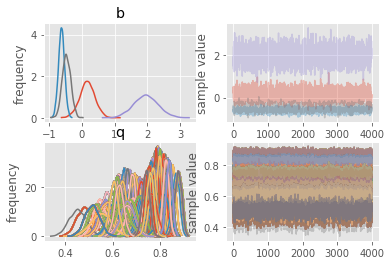

In [11]:
fit.plot()

In [12]:
sample_b1 = fit.extract('b')['b'][0]
sample_b2 = fit.extract('b')['b'][1]
sample_b3 = fit.extract('b')['b'][2]
sample_q = fit.extract('q')['q']
sample_lp__ = fit.extract('lp__')['lp__']

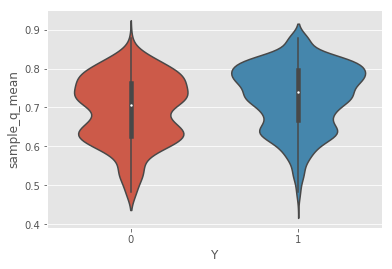

In [13]:
sample_q_mean = np.mean(sample_q, axis=0)
vio_df = pd.DataFrame([])
vio_df['sample_q_mean'] = sample_q_mean
vio_df['Y'] = data['Y']
sns.violinplot(data=vio_df, y='sample_q_mean', x='Y')